<a href="https://colab.research.google.com/github/ibalpalaloi/CPM-CIVIL-RAB/blob/master/Copy_of_CLASSIFICATION_TEXT_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
import matplotlib
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim
import gensim.downloader as api

# Various
from datetime import datetime

# Showing the versions used
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('PyPlot version: {}'.format(matplotlib.__version__))
print('Scikit Learn version: {}'.format(sklearn.__version__))
print('Tensorflow version: {}'.format(tf.__version__))
print('Transformers version: {}'.format(transformers.__version__))
print('Regex version: {}'.format(re.__version__))
print('NLTK version: {}'.format(nltk.__version__))
print('Gensim version: {}'.format(gensim.__version__))

Pandas version: 2.2.2
Numpy version: 1.26.4
PyPlot version: 3.8.0
Scikit Learn version: 1.5.2
Tensorflow version: 2.17.1
Transformers version: 4.46.3
Regex version: 2.2.1
NLTK version: 3.9.1
Gensim version: 4.3.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset = 'bbc-text'

if dataset=='bbc-text':
    datapath = "/content/drive/MyDrive/NLP/MAPPING_ASET.csv"
if dataset=='corona':
    datapath="/home/DATASET/Corona_NLP_test.csv"

df = pd.read_csv(datapath)

df = df[["AssetDescription", "GroupCode"]]


# Show the data
df.head()

,AssetDescription,GroupCode
0,Container 20ft Cargo Worthy Condition + Toilet...,FA-01-GE
1,Container 20ft Cargo Worthy Condition + Toilet...,FA-01-GE
2,Container 20ft Cargo Worthy Condition + Ruang ...,FA-01-GE
3,Container 20ft Cargo Worthy Condition + Ruang ...,FA-01-GE
4,Container 20ft Cargo Worthy Condition (Klinik),FA-01-GE


In [9]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by Group Code:')
print(df["GroupCode"].value_counts())
print(40*'-')
nr_categories = len(df["GroupCode"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 989
----------------------------------------
Split by Group Code:
GroupCode
FA-02-GE    257
FA-03-GE    248
FA-09-OP    151
FA-05-OP    122
FA-04-GE    100
FA-02-OP     62
FA-01-GE     19
FA-03-OP     12
FA-07-OP      7
FA-05-GE      2
FA-06-GE      2
FA-07-GE      2
FA-09-GE      2
FA-01-OP      1
FA-04-OP      1
FA-08-OP      1
Name: count, dtype: int64
----------------------------------------
Number of categories: 16


In [11]:
# You can adjust n:
n=100
print('Group Code: ',df['GroupCode'][n])
print(100*'-')
print('Description:')
print(df['AssetDescription'][n])

Group Code:  FA-02-GE
----------------------------------------------------------------------------------------------------
Description:
Cannon Ixus 220 


In [22]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk (that is used in the function below)
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
import nltk

In [15]:
nltk.download ('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [23]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["AssetDescription"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,AssetDescription,GroupCode,text_clean
0,Container 20ft Cargo Worthy Condition + Toilet...,FA-01-GE,container 20ft cargo worthy condition toilet d...
1,Container 20ft Cargo Worthy Condition + Toilet...,FA-01-GE,container 20ft cargo worthy condition toilet m...
2,Container 20ft Cargo Worthy Condition + Ruang ...,FA-01-GE,container 20ft cargo worthy condition ruang wu...
3,Container 20ft Cargo Worthy Condition + Ruang ...,FA-01-GE,container 20ft cargo worthy condition ruang wu...
4,Container 20ft Cargo Worthy Condition (Klinik),FA-01-GE,container 20ft cargo worthy condition klinik


In [41]:
# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['GroupCode']

In [42]:
y_train.value_counts()/y.value_counts()

,count
GroupCode,
FA-01-GE,0.684211
FA-02-GE,0.700389
FA-02-OP,0.693548
FA-03-GE,0.701613
FA-03-OP,0.666667
FA-04-GE,0.700000
FA-05-GE,0.500000
FA-05-OP,0.696721
FA-06-GE,1.000000


In [40]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['GroupCode'])

In [43]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [44]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [45]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 90.7%
Accuracy Test data: 77.0%
Training time: 1.0s


In [46]:
print('Classes of the model: ',classifier_tfidf.classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',classifier_tfidf.coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words = np.argsort(classifier_tfidf.coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = vectorizer_tfidf.vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

# Get for each category (=class) the top ten words
for n, w in enumerate(classifier_tfidf.classes_):
    t = w + ': '
    for i in range(NN):
        t += inv_voc[top_words[n,i]]
        if i!=NN:
            t+=', '
    print(t)
    print(80*'-')

Classes of the model:  ['FA-01-GE' 'FA-02-GE' 'FA-02-OP' 'FA-03-GE' 'FA-03-OP' 'FA-04-GE'
 'FA-05-GE' 'FA-05-OP' 'FA-06-GE' 'FA-07-GE' 'FA-07-OP' 'FA-09-GE'
 'FA-09-OP']
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (13, 3875)
--------------------------------------------------------------------------------
FA-01-GE: brimob, container, 20ft, 20ft cargo, worthy, cargo worthy, worthy condition, condition, cargo, container 20ft, 
--------------------------------------------------------------------------------
FA-02-GE: core, ac, genset, hytera, dispenser, pq, ht, camera, suunto, hq, 
--------------------------------------------------------------------------------
FA-02-OP: ph meter, meter, hand, pompa, ph, kompressor, grinder, hand grinder, makitech, pump, 
--------------------------------------------------------------------------------
FA-03-GE: led, samsung, led samsung, monitor, la

In [48]:
# Renaming, Input -> X, Output -> y
X_tf = df['AssetDescription']
y_tf_class = df['GroupCode']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_tf_class[n] + ' is ', y_tf[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['GroupCode'])

Coding of labels into a one-hot vector: FA-02-GE is  [0 1 0 0 0 0 0 0 0 0 0 0 0]


In [49]:
corpus = X_tf_train
max_words = 15000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [50]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (690, 200)
----------------------------------------------------------------------------------------------------
Example:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 695 101
  79 197]


In [51]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape

[==================================================] 100.0% 1662.8/1662.8MB downloaded


(300,)

In [57]:
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    # Check if the key exists in reverse_voc before accessing it
    if i + 1 in reverse_voc:
        w = reverse_voc[i+1]
        if w in w2v:
            emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [75]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'history' is not defined

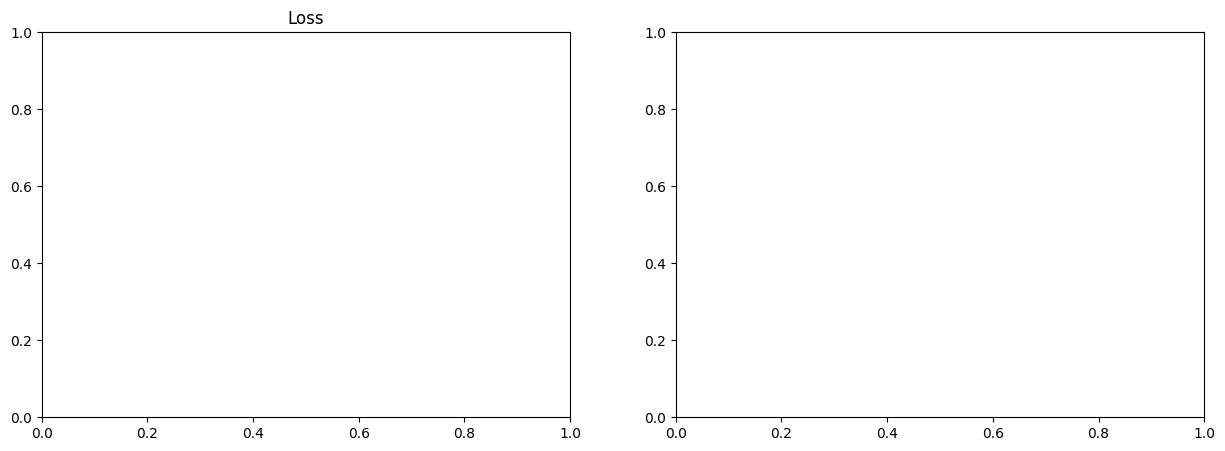

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [77]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 13), output.shape=(None, 16)

In [ ]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 96.3%
Accuracy Test data: 93.6%
Training time: 86.8s


In [ ]:
# Renaming, Input -> X, Output -> y
X_bert = df['text']
y_bert_class = df['category']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_bert_class)
y_bert = lab.transform(y_bert_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_bert_class[n] + ' is ', y_bert[n])

Coding of labels into a one-hot vector: entertainment is  [0 1 0 0 0]


In [78]:
# distil-bert tokenizer
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_bert = [tokenizer_bert(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in X_bert]
X_bert = np.array(X_bert, dtype='int32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

NameError: name 'X_bert' is not defined

In [80]:
# Train/test split
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y_bert, test_size=0.3, random_state=42, stratify=df['category'])
print('Shape of training data: ',X_bert_train.shape)

NameError: name 'X_bert' is not defined

In [79]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [65]:
# Let's create a sampe of size 5 from the training data
sample = X_bert_train[0:5]
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)

NameError: name 'X_bert_train' is not defined

In [66]:
input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=input_ids_in, outputs = x)

dmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'dbert' is not defined

In [67]:
dmodel.summary()

NameError: name 'dmodel' is not defined

In [68]:
# Train the model
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=32, shuffle=True, epochs=5, validation_data=(X_bert_test, y_bert_test))
end_time = datetime.now()

training_time_bert = (end_time - start_time).total_seconds()

NameError: name 'dmodel' is not defined

NameError: name 'history' is not defined

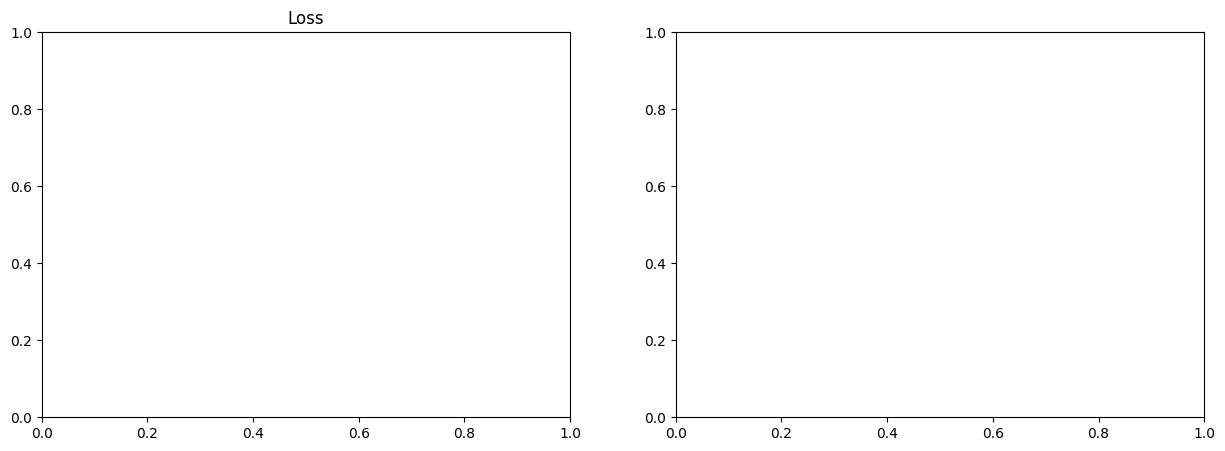

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [70]:
accuracy_bert = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_bert, training_time_bert/60))

NameError: name 'history' is not defined

In [71]:
method = ['TF-IDF', 'RNN', 'BERT']
accuracy = [accuracy_tfidf, accuracy_rnn, accuracy_bert]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_tfidf,1), round(training_time_rnn,1), round(training_time_bert,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

NameError: name 'accuracy_rnn' is not defined